## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print (images)

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration20.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg']


## And so on and so forth...

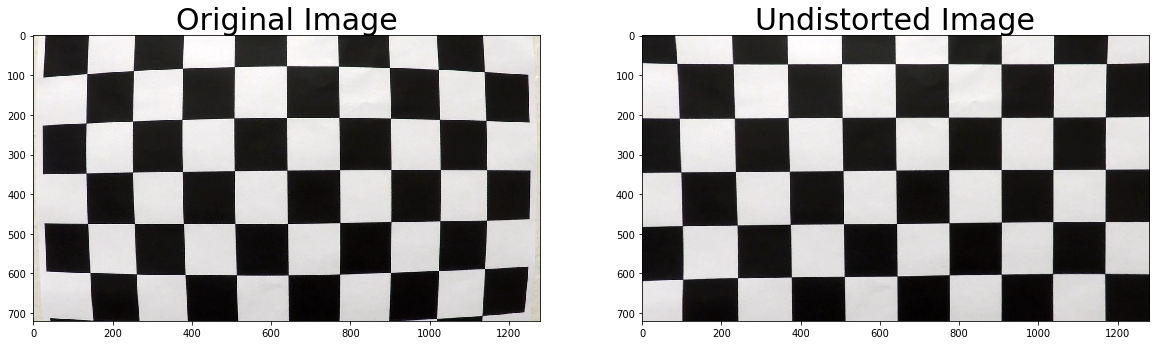

In [4]:
%matplotlib inline

# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#applied this distortion correction to the test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('image1.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

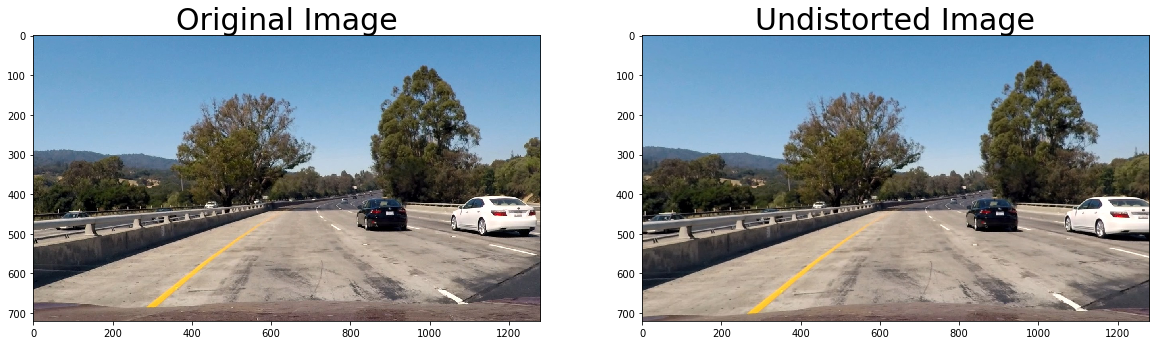

In [5]:
%matplotlib inline

# Test undistortion on an image
img = mpimg.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#applied this distortion correction to the test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
# image pipelne
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Grayscale image
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

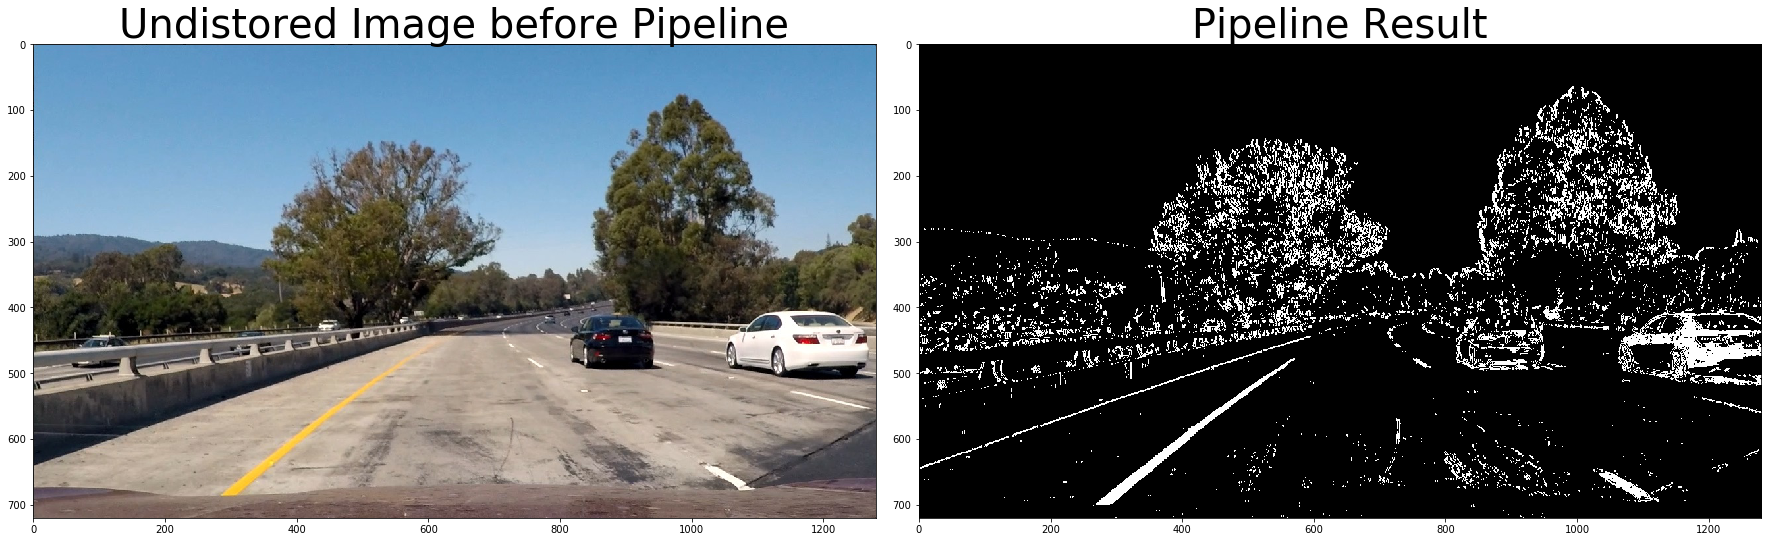

In [7]:
# Test undistortion on an image
#img = mpimg.imread('test_images/test1.jpg')
#img_size = (img.shape[1], img.shape[0])
result = pipeline(dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
mpimg.imsave('image2.png',img)
ax1.set_title('Undistored Image before Pipeline', fontsize=40)

ax2.imshow(result, cmap='gray')
mpimg.imsave('image3.png',result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40,)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
# Perspective Transform
def warper(img, nx, ny, mtx, dist):
    # remove distortion
#    img = cv2.undistort(img, mtx, dist, None, mtx)
#    undist = np.copy(img)  
    # Convert to grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_size = (gray.shape[1], gray.shape[0])
    width = img.shape[1]
    height = img.shape[0]
    src = np.array([[(width*0.4, height*0.65),
                        (width*0.6, height*0.65),
                        (width, height),
                        (0, height)]], 
                        dtype=np.float32)
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32') 
    # get the transform matrix
    M = cv2.getPerspectiveTransform(src, dst) 
    # Inverse Transform
    M_inv = cv2.getPerspectiveTransform(dst, src) 
    # warp image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv,src,dst

src [[[  512.   468.]
  [  768.   468.]
  [ 1280.   720.]
  [    0.   720.]]]
dst [[    0.     0.]
 [ 1280.     0.]
 [ 1280.   720.]
 [    0.   720.]]


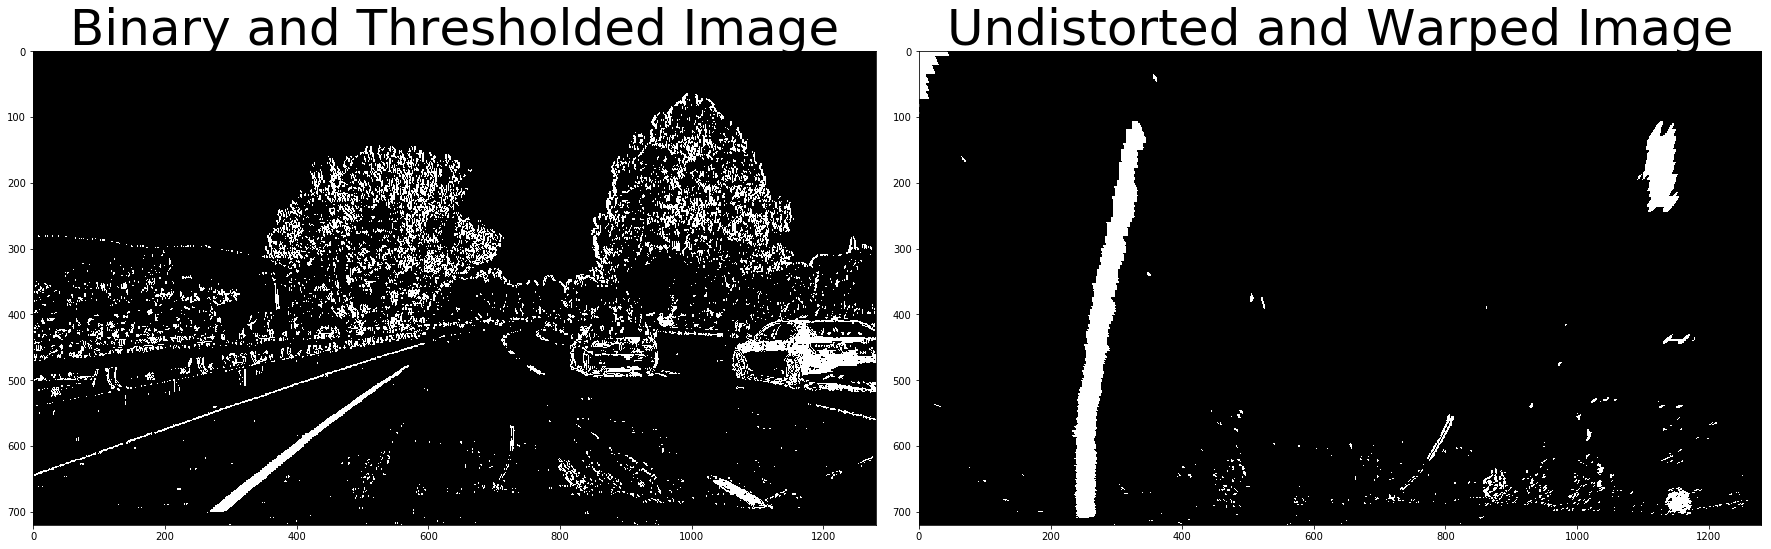

In [9]:
top_down, perspective_M, M_inv,src,dst = warper(result, nx, ny, mtx, dist)
print ('src',src)
print ('dst',dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.set_title('Binary and Thresholded Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

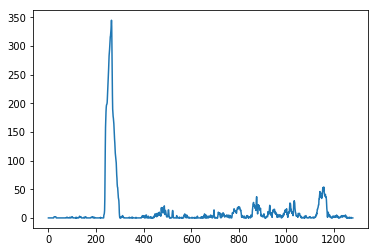

In [10]:
# Line Finding Method: Peaks in a Histogram
import numpy as np
def test(top_down):
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    return histogram

histogram = test(top_down)
plt.plot(histogram)

In [11]:
# Implement Sliding Windows and Fit a Polynomial
def sliding_windows(binary_warped):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit 

(720, 0)

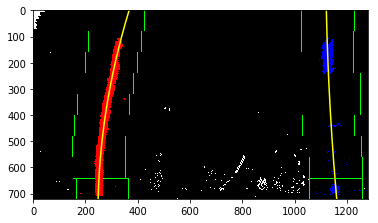

In [12]:
# Generate x and y values for plotting
binary_warped = top_down
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = sliding_windows(binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [13]:
# search in a margin around the previous line position with a new warped binary image 
# from the next frame of video (also called "binary_warped")

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

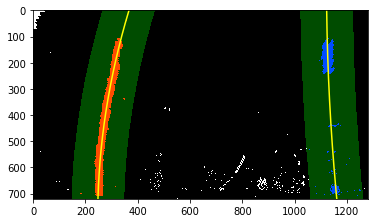

In [14]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [15]:
# Measuring Curvature
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

num_rows = top_down.shape[0]
left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 1864.89 m
Center offset: 0.34 m


In [18]:
# Add some calculations on the images, such as curvature and deviation (position from center)
def add_calculation_image(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

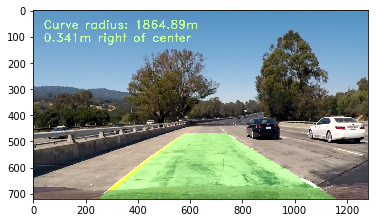

In [20]:
# Combine the processed image with the original image.
warped = top_down
out_img = np.dstack((warped, warped, warped))*255
y_points = np.linspace(0, num_rows-1, num_rows)
left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
result = add_calculation_image(result, average_curve_rad, center_offset_mtrs)
plt.imshow(result)

In [30]:
# Construct image Pipeline for general images. 
def process_image(image):
    img = image
    img_size = (img.shape[1], img.shape[0])
    #applied this distortion correction to the test image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    result = pipeline(dst)    
    top_down, perspective_M, M_inv, src, dst = warper(result, nx, ny, mtx, dist)
    binary_warped = top_down
    # sliding widnow
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = sliding_windows(binary_warped)

    # search in a margin around the previous line position with a new warped binary image 
    # from the next frame of video (also called "binary_warped")

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    num_rows = top_down.shape[0]
    left_curve_rad = measure_radius_of_curvature(left_fitx)
    right_curve_rad = measure_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad

    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs

    # Combine the processed image with the original image.
    out_img = np.dstack((warped, warped, warped))*255
    y_points = np.linspace(0, num_rows-1, num_rows)
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    result = add_calculation_image(result, average_curve_rad, center_offset_mtrs)
    return result

['test_images\\straight_lines1.jpg', 'test_images\\straight_lines2.jpg', 'test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']


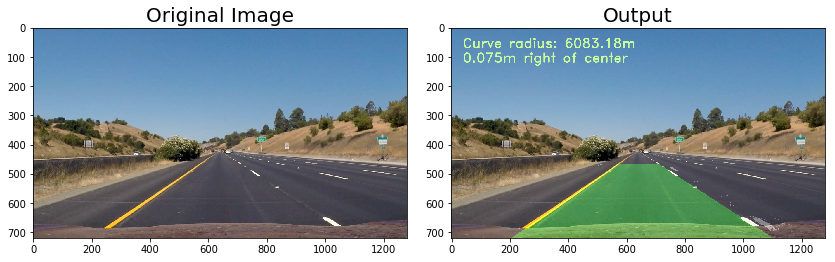

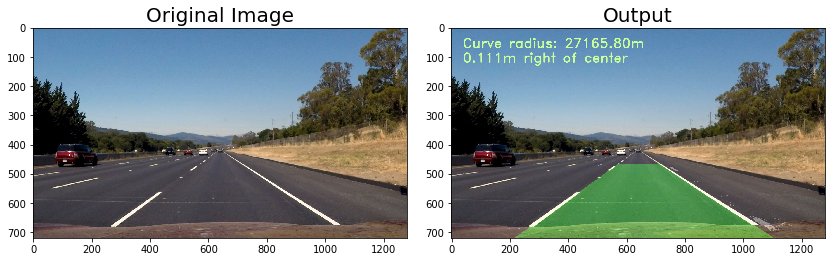

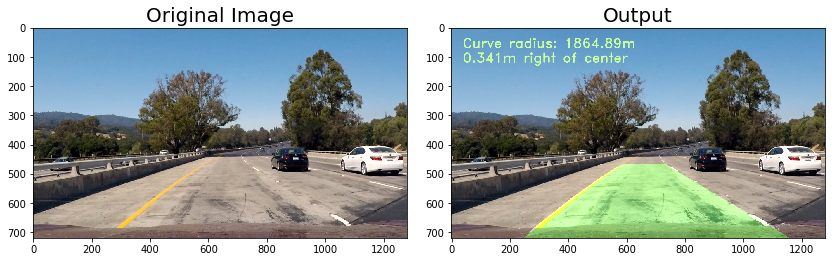

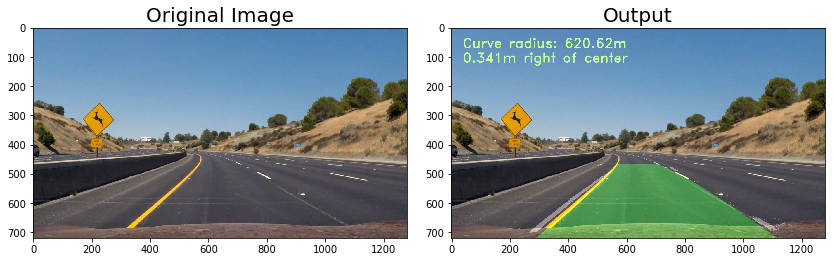

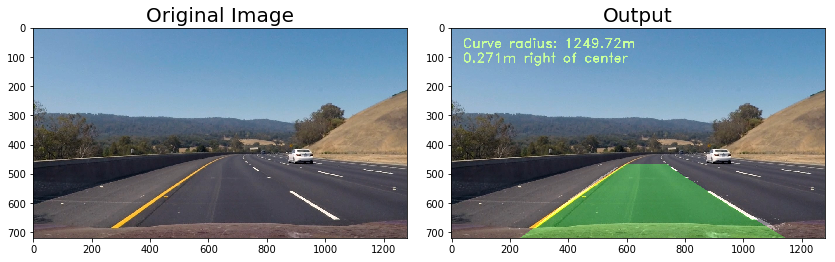

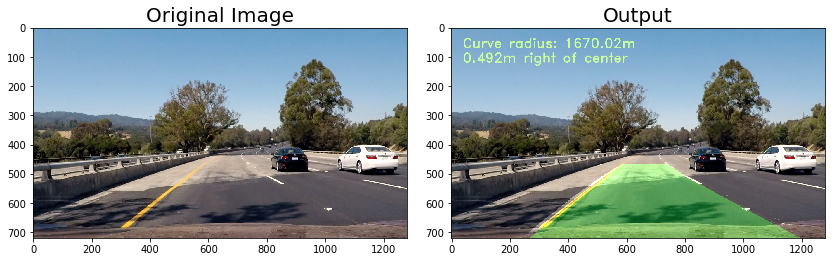

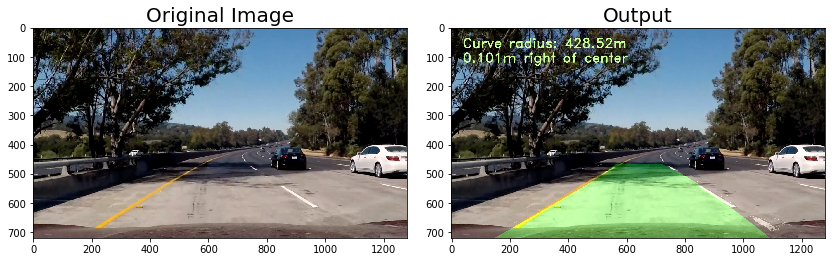

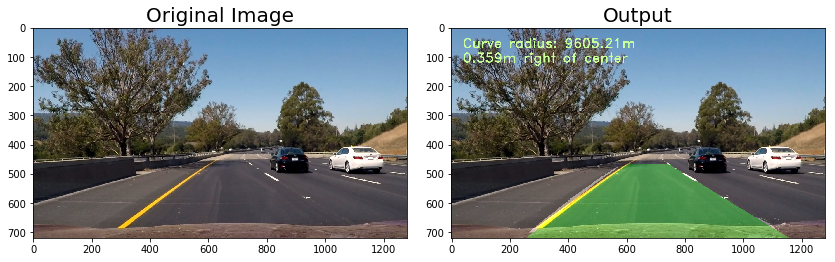

In [31]:
# draw detected lane lines on all test images
import os
#image = mpimg.imread('test_images/test3.jpg')
test_images = glob.glob('test_images/*.jpg')
print(test_images)

images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    image = mpimg.imread(fname)
    result = process_image(image)
           
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(result)
    ax2.set_title('Output', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [34]:
# draw detected lane lines on the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#for image in clip2.iter_frames():
# video output
write_output = 'project_video_out.mp4'
# video input 
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



  8%|███                                    | 101/1261 [00:48<10:23,  1.86it/s]


 16%|██████▎                                | 203/1261 [01:44<13:05,  1.35it/s]


 24%|█████████▍                             | 305/1261 [02:45<10:46,  1.48it/s]


 32%|████████████▌                          | 407/1261 [03:48<09:27,  1.51it/s]


 40%|███████████████▋                       | 509/1261 [04:56<08:32,  1.47it/s]


 48%|██████████████████▉                    | 611/1261 [06:01<07:21,  1.47it/s]


 57%|██████████████████████                 | 713/1261 [07:15<06:23,  1.43it/s]


 65%|█████████████████████████▏             | 815/1261 [08:40<05:53,  1.26it/s]


 73%|████████████████████████████▎          | 917/1261 [09:56<04:35,  1.25it/s]


 81%|██████████████████████████████▋       | 1019/1261 [11:13<03:21,  1.20it/s]


 89%|█████████████████████████████████▊    | 1121/1261 [13:06<02:35,  1.11s/it]


 97%|████████████████████████████████████▊ | 1223/1261 [14:40<00:34,  1.09it/s]


100%|█████████████████████████████████████▉| 1260/1261 [15:16<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 15min 21s


In [27]:
# draw detected lane lines on the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# video output
write_output = 'project_video_out2.mp4'
# video input 
clip1 = VideoFileClip("challenge_video.mp4")
write_clip = clip1.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out2.mp4
[MoviePy] Writing video project_video_out2.mp4


100%|████████████████████████████████████████| 485/485 [02:52<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out2.mp4 

Wall time: 2min 55s


In [28]:
# draw detected lane lines on the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# video output
write_output = 'project_video_out3.mp4'
# video input 
clip1 = VideoFileClip("harder_challenge_video.mp4")
write_clip = clip1.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out3.mp4
[MoviePy] Writing video project_video_out3.mp4


100%|█████████████████████████████████████▉| 1199/1200 [12:53<00:00,  1.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out3.mp4 

Wall time: 12min 59s
